#**<center>Natural Language Text to SQL Query Conversion**

###**Importing and installing required libraries**

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
pip install records

In [3]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import records
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import time
import unicodedata

from __future__ import unicode_literals, print_function, division

from collections import defaultdict
from io import open
from __future__ import unicode_literals, print_function, division

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from torch import optim

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
import os
import sys
sys.path.append('/content/drive/MyDrive/lib/')

In [6]:
from lib_db import *

###**Creating Required directories**

In [7]:
"""Required functions for directory creation"""
def check_if_dir_exists(directory):
    """
    Checks if 'directory' exists
    """
    return(os.path.isdir(directory))

def make_dir(directory):
    """
    Create directory
    """
    if not check_if_dir_exists(directory):
        os.mkdir(directory)
        print("Directory %s created successfully." %directory)
    else:
        print("Directory %s exists." %directory)

print("We are in:",os.getcwd())

"""
Required directory creation
"""
project_dir="/content/drive/MyDrive/Data606_finalproject"
make_dir(project_dir)


project_data_dir = project_dir + "/data/"
make_dir(project_data_dir)

project_result_dir = project_dir + "/output/"
make_dir(project_result_dir)

project_checkpoint_dir = project_dir + "/project_Checkpoint/"
make_dir(project_checkpoint_dir)

print(project_data_dir)

We are in: /content
Directory /content/drive/MyDrive/Data606_finalproject exists.
Directory /content/drive/MyDrive/Data606_finalproject/data/ exists.
Directory /content/drive/MyDrive/Data606_finalproject/output/ exists.
Directory /content/drive/MyDrive/Data606_finalproject/project_Checkpoint/ exists.
/content/drive/MyDrive/Data606_finalproject/data/


###**Listing files in Directories**

In [8]:
def list_dir(dir_path):
  """
  List directories for a given path
  """
  print("Directory %s contains : " %dir_path)
  for dir_or_file in os.listdir(dir_path):
    print(dir_or_file)
  print("\n")

"""
List created directories
"""
print('Current directory : ', os.getcwd(),'\n')
list_dir(project_dir)
list_dir(project_data_dir)
list_dir(project_checkpoint_dir)

Current directory :  /content 

Directory /content/drive/MyDrive/Data606_finalproject contains : 
data
output
project_Checkpoint
Data606_Project_preprocess.ipynb


Directory /content/drive/MyDrive/Data606_finalproject/data/ contains : 
test.tables.jsonl
dev.tables.jsonl
train.tables.jsonl
dev.db
train.db
test.db
train.jsonl
dev.jsonl
test.jsonl


Directory /content/drive/MyDrive/Data606_finalproject/project_Checkpoint/ contains : 




In [9]:
train_data = pd.read_json('/content/drive/MyDrive/Data606_finalproject/data/train.jsonl', lines=True )

train_data.head()

,phase,table_id,question,sql
0,1,1-1000181-1,Tell me what the notes are for South Australia,"{'sel': 5, 'conds': [[3, 0, 'SOUTH AUSTRALIA']..."
1,1,1-1000181-1,What is the current series where the new serie...,"{'sel': 4, 'conds': [[5, 0, 'New series began ..."
2,1,1-1000181-1,What is the format for South Australia?,"{'sel': 2, 'conds': [[0, 0, 'South Australia']..."
3,1,1-1000181-1,Name the background colour for the Australian ...,"{'sel': 1, 'conds': [[0, 0, 'Australian Capita..."
4,1,1-10007452-3,how many times is the fuel propulsion is cng?,"{'sel': 3, 'conds': [[5, 0, 'CNG']], 'agg': 3}"


In [10]:
train_tables_data = pd.read_json('/content/drive/MyDrive/Data606_finalproject/data/train.tables.jsonl', lines=True )

train_tables_data.head()

,id,header,types,rows,name,page_title,section_title,caption,page_id
0,1-1000181-1,"[State/territory, Text/background colour, Form...","[text, text, text, text, text, text]","[[Australian Capital Territory, blue/white, Ya...",table_1000181_1,NaN,NaN,NaN,NaN
1,1-10006830-1,"[Aircraft, Description, Max Gross Weight, Tota...","[text, text, text, text, text]","[[Robinson R-22, Light utility helicopter, 1,3...",table_10006830_1,Disk loading,Examples,Disk loading comparison,NaN
2,1-10007452-3,"[Order Year, Manufacturer, Model, Fleet Series...","[text, text, text, text, text, text]","[[1992-93, Gillig, Phantom (High Floor), 444-4...",table_10007452_3,Torrance Transit,Fleet,Fleet,NaN
3,1-10015132-1,"[Player, No., Nationality, Position, Years in ...","[text, text, text, text, text, text]","[[Quincy Acy, 4, United States, Forward, 2012-...",table_10015132_1,Toronto Raptors all-time roster,A,A,NaN
4,1-10015132-14,"[Player, No., Nationality, Position, Years in ...","[text, real, text, text, text, text]","[[Patrick O'Bryant, 13, United States, Center,...",table_10015132_14,Toronto Raptors all-time roster,O,O,NaN


###**Text Preprocessing**

In [11]:

class DataConversionUtil:
    """Class is responsible for converting all the sql structured output to plain text sql queries"""

    def __init__(self):
        self.table_map = {}  # key is table_id, value is all the table data

    def build_table_mapping(self, dataset):
        """Reads the tables file and creates a dictionary with table id as key and all other data as value"""
        tables = pd.read_json("/content/drive/MyDrive/Data606_finalproject/data/" + dataset + ".tables.jsonl", lines=True)
        data = pd.DataFrame()
        for index, line in tables.iterrows():  
            self.table_map[line["id"]] = line
            line["tokenized_header"] = []
            for column_header in line["header"]:
                line["tokenized_header"].append(self.tokenize_document(column_header))
            line_df = pd.DataFrame(line)
            line_df = line_df.transpose()
            data = data.append(line_df)
        self.save_dataframe(data, "/content/drive/MyDrive/Data606_finalproject/output/tokenized_" + dataset + ".tables.jsonl")

    def get_query_from_json(self, json_line):
        """Returns a Query object for the json input and returns the table object as well"""
        q = Query.from_dict(json_line["sql"])
        t_id = json_line["table_id"]
        table = self.table_map[t_id]
        t = Table("", table["header"], table["types"], table["rows"])
        return t, q

    @staticmethod
    def execute_query(table, query):
        """Executes a query on the sqlite training db. Only for testing purposes"""
        db = records.Database('sqlite:///../data/train.db')
        conn = db.get_connection()
        query, result = table.execute_query(conn, query)
        conn.close()
        print(query, result)

    @staticmethod
    def tokenize_document(doc, print_token = False):
        operators = {'=' : 'EQL', '>' : 'GT', '<' : 'LT'}
        syntax_tokens = ["SELECT", "COUNT", "WHERE", "AND", "OR", "FROM"]
        tokens = nltk.word_tokenize(doc)
        for i in range(len(tokens)):
            if tokens[i] in syntax_tokens:
                continue
            if tokens[i] in operators.keys():
                tokens[i] = operators[tokens[i]]
            else:
                tokens[i] = tokens[i].lower()
        return tokens

    @staticmethod
    def save_dataframe(data, filename):
        data.to_json(filename, orient='records', lines=True)


    def build_tokenized_dataset(self, dataset):
        """Reads the input training files and generates a new file containing plain text sql queries"""
        self.build_table_mapping(dataset) #creates a dictionary with table id as key and all other data as value
        
        queries = pd.read_json("/content/drive/MyDrive/Data606_finalproject/data/" + dataset + ".jsonl", lines=True)

        count = 0
        stop_limit = len(queries)
        data = pd.DataFrame()

        # stop_limit = 10
        # iterate over the queries and convert each one to plain text sql
        for index, line in queries.iterrows():  # @UnusedVariable
            count += 1
            # get table and query representations
            table, query = self.get_query_from_json(line)
            
            # append query to dict, to add it to the datafram
            query_str = table.query_str(query)

            # Tokenize the query
            tokenized_query = self.tokenize_document(query_str, print_token = True)
            line["tokenized_query"] = tokenized_query
            
            # Fix the formatting of the query (lowercase + Uppercase syntax tokens)
            line["query"] = " ".join(tokenized_query)
            
            # Tokenize the question
            tokenized_question = self.tokenize_document(line["question"])
            line["tokenized_question"] = tokenized_question

            line_df = pd.DataFrame(line)
            line_df = line_df.transpose()
            data = data.append(line_df)

            if count > stop_limit:
                break
        
        # Save dataframe to file
        self.save_dataframe(data, "/content/drive/MyDrive/Data606_finalproject/output/tokenized_" + dataset + ".jsonl")

In [12]:
data_converter = DataConversionUtil()
data_converter.build_tokenized_dataset("train")
data_converter.build_tokenized_dataset("dev")
data_converter.build_tokenized_dataset("test")

In [13]:
train_tokenized_data = pd.read_json('/content/drive/MyDrive/Data606_finalproject/output/tokenized_train.jsonl', lines=True )

train_tokenized_data.head()

,phase,table_id,question,sql,tokenized_query,query,tokenized_question
0,1,1-1000181-1,Tell me what the notes are for South Australia,"{'sel': 5, 'conds': [[3, 0, 'SOUTH AUSTRALIA']...","[SELECT, notes, FROM, table_, WHERE, current, ...",SELECT notes FROM table_ WHERE current slogan ...,"[tell, me, what, the, notes, are, for, south, ..."
1,1,1-1000181-1,What is the current series where the new serie...,"{'sel': 4, 'conds': [[5, 0, 'New series began ...","[SELECT, current, series, FROM, table_, WHERE,...",SELECT current series FROM table_ WHERE notes ...,"[what, is, the, current, series, where, the, n..."
2,1,1-1000181-1,What is the format for South Australia?,"{'sel': 2, 'conds': [[0, 0, 'South Australia']...","[SELECT, format, FROM, table_, WHERE, state/te...",SELECT format FROM table_ WHERE state/territor...,"[what, is, the, format, for, south, australia, ?]"
3,1,1-1000181-1,Name the background colour for the Australian ...,"{'sel': 1, 'conds': [[0, 0, 'Australian Capita...","[SELECT, text/background, colour, FROM, table_...",SELECT text/background colour FROM table_ WHER...,"[name, the, background, colour, for, the, aust..."
4,1,1-10007452-3,how many times is the fuel propulsion is cng?,"{'sel': 3, 'conds': [[5, 0, 'CNG']], 'agg': 3}","[SELECT, COUNT, (, fleet, series, (, quantity,...",SELECT COUNT ( fleet series ( quantity ) ) FRO...,"[how, many, times, is, the, fuel, propulsion, ..."


###**Seq2Seq Model Implementation**

In [14]:
#constants
MAX_LENGTH = 50
SOS_token = 0
EOS_token = 1
teacher_forcing_ratio = 1
GPU = True
BATCH_SIZE = 64
TRAINING_EPOCHS = 50
LEARNING_RATE = 1e-3

###**Encoder**

In [15]:
"""
Device
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"""
RNN Encoder
"""
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

###**Decoder**

In [16]:
"""
Decoder
"""
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

"""
Attention Decoder
"""

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

###**Preparing Training Data**

In [23]:

class LanguageUtil:
    def __init__(self, name):
        self.name = name
        self.word2index = defaultdict(int)
        self.word2count = defaultdict(int)
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


def readLangs(lang1, lang2):
    print("Reading lines...")

    lines = pd.read_json("/content/drive/MyDrive/Data606_finalproject/output/tokenized_train.jsonl", lines=True)

    # Split every line into pairs and normalize
    pairs = []
    for idx, row in lines.iterrows():
        tokens_en = row["tokenized_question"]
        tokens_sql = row["tokenized_query"]
        pairs.append([tokens_en, tokens_sql])

    input_lang = LanguageUtil(lang1)
    output_lang = LanguageUtil(lang2)

    return input_lang, output_lang, pairs


def prepareValData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs_val(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


def readLangs_val(lang1, lang2):
    print("Reading lines...")

    lines = pd.read_json("/content/drive/MyDrive/Data606_finalproject/output/tokenized_dev.jsonl", lines=True)

    # Split every line into pairs and normalize
    pairs = []
    for idx, row in lines.iterrows():
        tokens_en = row["tokenized_question"]
        tokens_sql = row["tokenized_query"]
        pairs.append([tokens_en, tokens_sql])

    input_lang = LanguageUtil(lang1)
    output_lang = LanguageUtil(lang2)

    return input_lang, output_lang, pairs


def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

###**Training the model**

In [17]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length-1): #changed 1,+1
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True  # if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [19]:
def trainIters(encoder, decoder, n_iters, print_every=10, plot_every=20, learning_rate=0.0005):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang) for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses, "Baseline loss")

###**Plotting Results**

In [18]:

def showPlot(points, plot_name):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig(plot_name + ".png")


def plot_data(x, y, xlabel = "x", ylabel = "y", label = 'plot'):
	plt.figure()
	plt.plot(x, y)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	print("Generating plot for ", label)
	plt.savefig("./" + label + ".png")

##**Evaluation**

In [20]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [21]:
def evaluateRandomly(encoder, decoder, n=1000):
    correct = 0
    for i in range(n):
        pair = random.choice(pairs)
        print('\nEnglish Question-', pair[0])
        print('Ground truth Query-', pair[1])
        generated_tokens, attentions = evaluate(encoder, decoder, pair[0])
        generated_query = ' '.join(generated_tokens)
        if generated_query[:-6] == pair[1]:
            correct += 1
        print('Generated Query-', generated_query)
    print("\n\nCorrect Examples : {} out of {}".format(correct, n))
    return correct / n * 100

In [22]:
def hyperparam(hidden_size):

    global input_lang
    global output_lang
    global pairs
    input_lang, output_lang, pairs = prepareValData("en", "sql")
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
    lr = [0.0001, 0.001, 0.01, 0.1, 1]
    high = 0
    best_lr = 0
    for l in lr:
        print("Searching for best params...")
        trainIters(encoder1, attn_decoder1, 10000, print_every=1000, plot_every=1000,learning_rate=l) #Change number of iter
        accuracy = evaluateRandomly(encoder1,attn_decoder1, n=10)
        if(accuracy > high):
            best_lr = l
    return best_lr

###**Training and Evaluating**

Reading lines...
Read 56355 sentence pairs
Trimmed to 56355 sentence pairs
Counting words...
Counted words:
en 39685
sql 38066
(1000 10%) 4.0705
(2000 20%) 3.4827
(3000 30%) 3.2191
(4000 40%) 3.0928
(5000 50%) 2.8806
(6000 60%) 2.9306
(7000 70%) 2.7266
(8000 80%) 2.6585
(9000 90%) 2.6324
(10000 100%) 2.6248

English Question- ['was', 'the', 'round', 'where', 'they', 'were', 'in', '6th', 'at', 'home', 'or', 'away', '?']
Ground truth Query- ['SELECT', 'home/away', 'FROM', 'table_', 'WHERE', 'position', 'on', 'ladder', 'EQL', '6th']
Generated Query- SELECT venue FROM table_ WHERE away team EQL detroit AND round EQL 11 <EOS>

English Question- ['which', 'is', 'the', 'earliest', 'founded', 'day', 'school', 'to', 'have', 'entered', 'the', 'competition', 'after', '1958', '?']
Ground truth Query- ['SELECT', 'min', '(', 'founded', ')', 'FROM', 'table_', 'WHERE', 'day/boarding', 'EQL', 'day', 'AND', 'year', 'entered', 'competition', 'GT', '1958']
Generated Query- SELECT min ( year ) FROM table_ 

<Figure size 432x288 with 0 Axes>

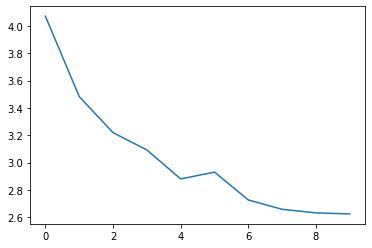

In [24]:
def run_baseline():
    hidden_size = 256
    x = DataConversionUtil()
    #lr_best = hyperparam(hidden_size)
    
    global input_lang
    global output_lang
    global pairs
    input_lang, output_lang, pairs = prepareData("en", "sql")
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
    attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
    trainIters(encoder1, attn_decoder1, 10000, print_every=1000, plot_every=1000,learning_rate= 1e-3)
    acc = evaluateRandomly(encoder1, attn_decoder1, n=1000)
    print("Accuracy achieved:", acc)


if __name__ == '__main__':
    run_baseline()